In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
import warnings
import sqlite3

# Suppress warnings
warnings.filterwarnings('ignore')



In [2]:
# Loading the dataset
df = pd.read_csv(r'C:\Users\user\Downloads\Data-&-Problem-Statement---Project----2 (1)\Credit card transactions - Project - 2.csv')

# Displaying the first few rows of the dataset
df.head()

# Check for missing values
print(df.isnull().sum())

# Check for duplicate rows
print(df.duplicated().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Fill missing values with appropriate strategies
df['Amount'].fillna(df['Amount'].median(), inplace=True)
df['City'].fillna('Unknown', inplace=True)
df['Gender'].fillna('Unknown', inplace=True)


index        0
City         0
Date         0
Card Type    0
Exp Type     0
Gender       0
Amount       0
dtype: int64
0


In [3]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Create new features based on Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

# Feature: Transaction Amount per Year and Month (Aggregates)
df['Amount_per_month'] = df.groupby(['Year', 'Month'])['Amount'].transform('sum')

# CASE WHEN equivalent in pandas: Categorize Amount into High, Medium, Low
df['Amount_Category'] = pd.cut(df['Amount'], bins=[0, 50000, 100000, np.inf], labels=['Low', 'Medium', 'High'])

# Check the new features
df.head()


,index,City,Date,Card Type,Exp Type,Gender,Amount,Year,Month,Day,Weekday,Amount_per_month,Amount_Category
0,0,"Delhi, India",2014-10-29,Gold,Bills,F,82475,2014,10,29,2,212485915,Medium
1,1,"Greater Mumbai, India",2014-08-22,Platinum,Bills,F,32555,2014,8,22,4,218453126,Low
2,2,"Bengaluru, India",2014-08-27,Silver,Bills,F,101738,2014,8,27,2,218453126,High
3,3,"Greater Mumbai, India",2014-04-12,Signature,Bills,F,123424,2014,4,12,5,208284732,High
4,4,"Bengaluru, India",2015-05-05,Gold,Bills,F,171574,2015,5,5,1,173693297,High


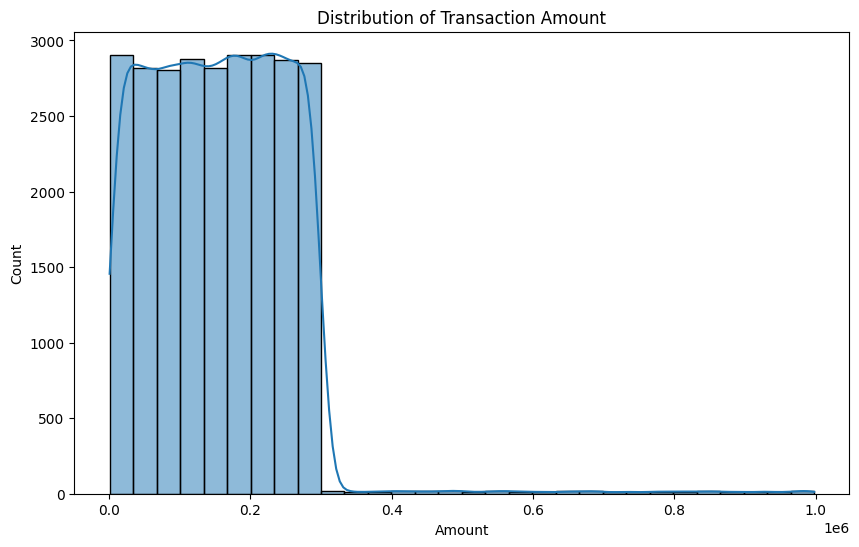

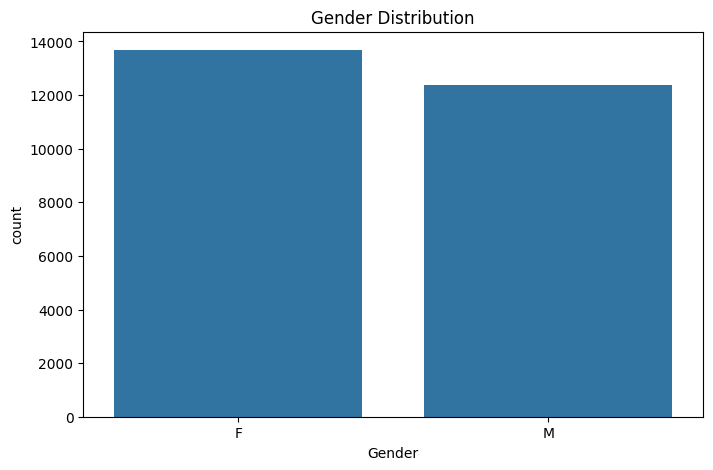

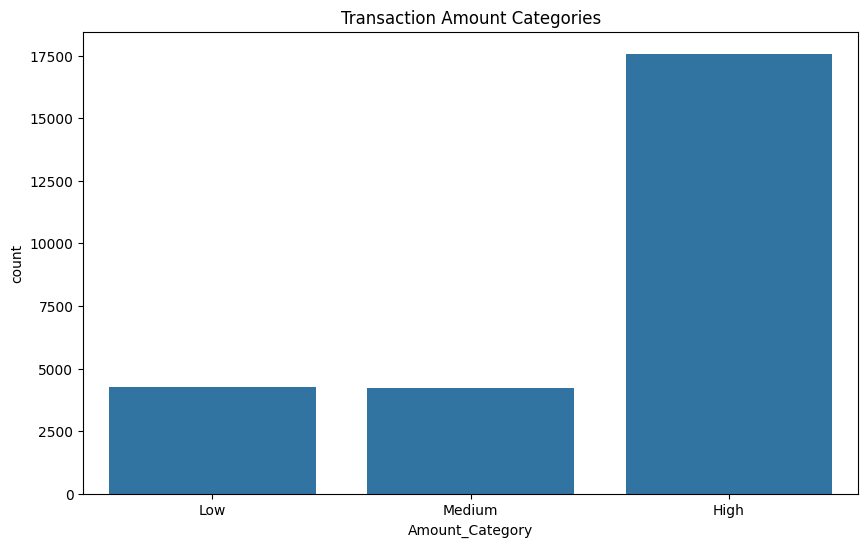

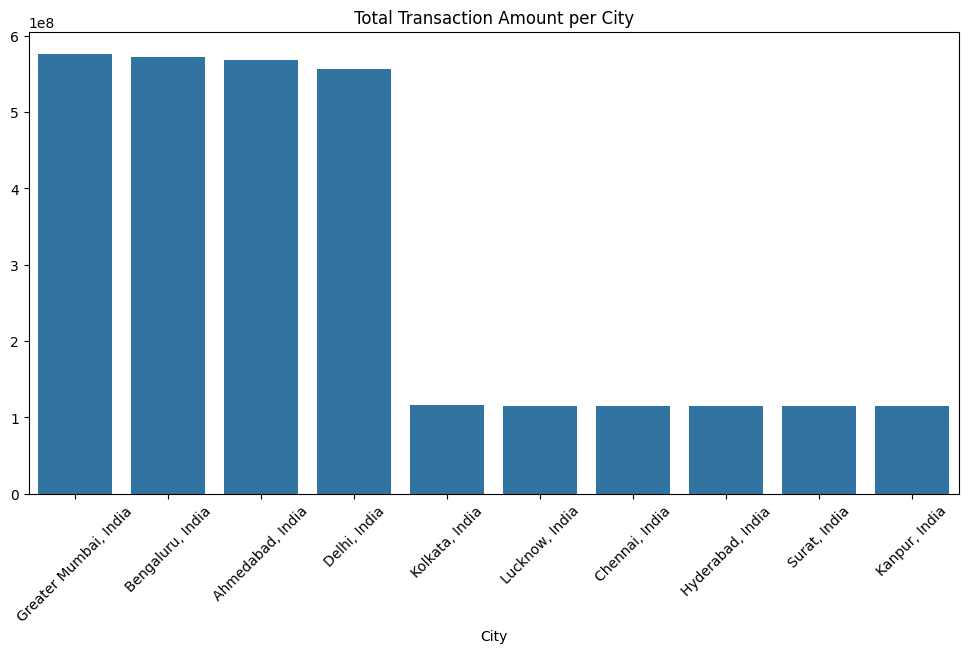

In [4]:
# Distribution of Transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], kde=True, bins=30)
plt.title('Distribution of Transaction Amount')
plt.show()

# Gender Distribution in Transactions
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

# Amount Category distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Amount_Category', data=df)
plt.title('Transaction Amount Categories')
plt.show()

# Total amount spent per City
city_spend = df.groupby('City')['Amount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=city_spend.index, y=city_spend.values)
plt.title('Total Transaction Amount per City')
plt.xticks(rotation=45)
plt.show()


In [5]:
# Label Encoding for Categorical Data
label_encoder = LabelEncoder()

df['City_Encoded'] = label_encoder.fit_transform(df['City'])
df['Card_Type_Encoded'] = label_encoder.fit_transform(df['Card Type'])
df['Exp_Type_Encoded'] = label_encoder.fit_transform(df['Exp Type'])
df['Gender_Encoded'] = label_encoder.fit_transform(df['Gender'])


In [6]:
# Selecting relevant features for fraud prediction
features = ['Amount', 'Year', 'Month', 'Day', 'Weekday', 'Amount_per_month', 'City_Encoded', 
            'Card_Type_Encoded', 'Exp_Type_Encoded', 'Gender_Encoded']
X = df[features]
y = df['Amount_Category']  # Assuming this is the target for fraud detection (classification problem)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the data (Important for some ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Train RandomForest model
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print('RandomForest Classifier Report')
print(classification_report(y_test, y_pred_rf))

# Train Logistic Regression model
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print('Logistic Regression Report')
print(classification_report(y_test, y_pred_lr))

# Train DecisionTree model
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
print('Decision Tree Report')
print(classification_report(y_test, y_pred_dt))


RandomForest Classifier Report
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      5232
         Low       1.00      1.00      1.00      1332
      Medium       1.00      1.00      1.00      1252

    accuracy                           1.00      7816
   macro avg       1.00      1.00      1.00      7816
weighted avg       1.00      1.00      1.00      7816

Logistic Regression Report
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      5232
         Low       1.00      1.00      1.00      1332
      Medium       0.99      0.99      0.99      1252

    accuracy                           1.00      7816
   macro avg       1.00      1.00      1.00      7816
weighted avg       1.00      1.00      1.00      7816

Decision Tree Report
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      5232
         Low       1.00      1.00      1.00      1

In [8]:
# Example of SQL Join: Merge two DataFrames (e.g., Transaction data with customer data)
# Assuming we have another dataframe with customer info (Not included here for brevity)
customer_df = pd.DataFrame({'CustomerID': [1, 2, 3], 'CustomerName': ['A', 'B', 'C']})
merged_df = pd.merge(df, customer_df, left_on='City_Encoded', right_on='CustomerID', how='inner')

# Window Functions: Get the rank of each transaction based on Amount per City
df['Amount_Rank'] = df.groupby('City')['Amount'].rank(method='dense', ascending=False)

# Using `LEAD` function to show the next transaction amount for each record
df['Next_Transaction_Amount'] = df.groupby('City')['Amount'].shift(-1)

# Display the final dataframe with additional features
df.head()


,index,City,Date,Card Type,Exp Type,Gender,Amount,Year,Month,Day,Weekday,Amount_per_month,Amount_Category,City_Encoded,Card_Type_Encoded,Exp_Type_Encoded,Gender_Encoded,Amount_Rank,Next_Transaction_Amount
0,0,"Delhi, India",2014-10-29,Gold,Bills,F,82475,2014,10,29,2,212485915,Medium,126,0,0,0,2505.0,100036.0
1,1,"Greater Mumbai, India",2014-08-22,Platinum,Bills,F,32555,2014,8,22,4,218453126,Low,170,1,0,0,3113.0,123424.0
2,2,"Bengaluru, India",2014-08-27,Silver,Bills,F,101738,2014,8,27,2,218453126,High,71,3,0,0,2417.0,171574.0
3,3,"Greater Mumbai, India",2014-04-12,Signature,Bills,F,123424,2014,4,12,5,208284732,High,170,2,0,0,2131.0,150980.0
4,4,"Bengaluru, India",2015-05-05,Gold,Bills,F,171574,2015,5,5,1,173693297,High,71,0,0,0,1614.0,434427.0


In [9]:
# Summarizing the project and results
print("Modeling Summary: RandomForest, LogisticRegression, and DecisionTree were used to classify transactions.")
print("Next steps: Implement fraud detection logic, hyperparameter tuning, and optimization.")


Modeling Summary: RandomForest, LogisticRegression, and DecisionTree were used to classify transactions.
Next steps: Implement fraud detection logic, hyperparameter tuning, and optimization.
